In [1]:
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ihop.community2vec import GensimCommunity2Vec
import ihop.clustering as ic

sns.set_palette("Dark2")
#sns.set_palette("gist_gray_r")

In [2]:
DATA_ROOT = Path("../data")
C2V_ROOT = DATA_ROOT / "community2vec"
VIZ_PATH = DATA_ROOT / "paper_visuals"
# Output path, save models as you go for convenience
MODEL_COMPARISON_ROOT = DATA_ROOT / "kmeans_vs_agglomerative"

N_CLUSTERS = [5, 10, 50, 100, 175, 250, 400]

MONTHS = sorted(["2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12", "2022-01", "2022-02", "2022-03"
])

C2V_MODELS = [GensimCommunity2Vec.load(C2V_ROOT / f"RC_{m}"/"best_model") for m in MONTHS]

#Recall that cosine distance and euclidean distance are equivalent with normed vectors, which is what Gensim returns
# tuples of (quick model type, pretty print model type, {model settings for training})
CLUSTER_MODEL_SETTINGS = [
    ("kmeans", "KMeans++", {"model_choice":"kmeans", "n_clusters":N_CLUSTERS, "random_state":97}),
    ("ward_agglomerative", "Ward Agglomerative", {"model_choice":"agglomerative", "linkage":"ward", "n_clusters":N_CLUSTERS, "affinity":"euclidean" }),
    ("average_agglomerative", "Average Agglomerative", {"model_choice":"agglomerative", "linkage":"average", "affinity":"euclidean", "n_clusters":N_CLUSTERS }),
    ("complete_agglomerative", "Complete Agglomerative", {"model_choice":"agglomerative", "linkage":"complete", "affinity":"euclidean", "n_clusters":N_CLUSTERS})
]


# Goal
The goal of this notebook is to quantitatively capture the differences in clustering between clusters of subreddits created using KMeans vs those created using hierarchical agglomerative clustering from the same underlying community2vec models in terms of:
- Variation of cluster size (how many subreddits assigned to each cluster)
- Silhouette Coefficient: Ranges between -1 (clustering is totally incorrect) and 1 (clusters are dense and well separated), scores around 0 indicate overlapping clusters.  
- Calinski-Harabasz Index: Higher for models with clusters that are dense and well separated.
- Davies-Bouldin Index: Measures separation/similarity between clusters by taking ratio of within-cluster distances to between-cluster distances. The minimum is zero, lower scores indicate better separation

# Train and Save Models
For each month, train a Kmeans++ model and the 3 agglomerative cluster models with different settings. 

In [3]:
metrics_collection =[]
for nc in N_CLUSTERS:
    print("Number clusters:", nc)
    for month, c2v_model in zip(MONTHS, C2V_MODELS):
        print("\tProcessing", month)
        vectors = c2v_model.w2v_model.wv
        data = c2v_model.get_normed_vectors()
        index = dict(enumerate(vectors.index_to_key))
        for label, pprint_label, model_params in CLUSTER_MODEL_SETTINGS:
            curr_model_path = MODEL_COMPARISON_ROOT / month / str(nc) / label
            # Read in existing model
            if curr_model_path.exists() and curr_model_path.is_dir():
                curr_model = ic.ClusteringModel.load(curr_model_path, data, index)
                model_name = curr_model.model_name
                metrics = curr_model.get_metrics()

            # Train and save a missing model
            else: 
                curr_model_path.mkdir(parents=True)
                params = model_params.copy()
                params["n_clusters"] = nc
                model_name = f"{month}_{label}"
                curr_model = ic.ClusteringModelFactory.init_clustering_model(model_choice=params.pop("model_choice"), data=data, index=index, model_name=model_name, **params)
                curr_model.train()
                curr_model.save(curr_model_path)
                curr_model.get_cluster_results_as_df().to_csv(curr_model_path / "clusters.csv", index=False)

                metrics = curr_model.write_metrics((curr_model_path / "metrics.json"))

            # Cluster size mean is just for sanity check, it should alwasy be fixed by N_CLUSTERS
            cluster_size_counts = list(Counter(curr_model.clusters).values())
            mean = np.mean(cluster_size_counts)
            max_cluster_size = np.max(cluster_size_counts)
            std_dev = np.std(cluster_size_counts)
            metrics["cluster_size_mean"] = mean
            metrics["Standard Deviation of Cluster Size"] = std_dev
            metrics["Size of Largest Cluster"] = max_cluster_size
            metrics["month"] = month
            metrics["experiment_label"] = pprint_label
            metrics["n_clusters"] = nc

            metrics_collection.append(metrics)

model_metrics_df = pd.DataFrame.from_records(metrics_collection)


Number clusters: 5
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01
	Processing 2022-02
	Processing 2022-03
Number clusters: 10
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01
	Processing 2022-02
	Processing 2022-03
Number clusters: 50
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01
	Processing 2022-02
	Processing 2022-03
Number clusters: 100
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01


In [4]:
pd.set_option('display.max_rows', None)
display(model_metrics_df)
model_metrics_df.write_csv(MODEL_COMPARISON_ROOT / "summary_metrics.csv", index=False)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,cluster_size_mean,Standard Deviation of Cluster Size,Size of Largest Cluster,month,experiment_label,n_clusters
0,0.098049,363.381135,4.210094,2000.000000,425.568796,2340,2021-04,KMeans++,5
1,0.073981,292.093144,5.068465,2000.000000,472.649130,2560,2021-04,Ward Agglomerative,5
2,0.174184,2.613877,2.032014,2000.000000,3994.000150,9988,2021-04,Average Agglomerative,5
3,0.036964,151.540229,3.888845,2000.000000,2529.974308,6798,2021-04,Complete Agglomerative,5
4,0.103241,371.054839,4.119707,2000.000000,381.650102,2515,2021-05,KMeans++,5
5,0.072362,296.392453,4.875028,2000.000000,593.509225,2994,2021-05,Ward Agglomerative,5
6,0.236781,2.988912,2.054409,2000.000000,3993.500119,9987,2021-05,Average Agglomerative,5
7,0.021656,79.478048,5.129734,2000.000000,2200.237805,5979,2021-05,Complete Agglomerative,5
8,0.105906,384.524950,4.183559,2000.000000,366.131124,2349,2021-06,KMeans++,5
9,0.073592,303.128902,4.763033,2000.000000,845.302076,3555,2021-06,Ward Agglomerative,5


AttributeError: 'DataFrame' object has no attribute 'write_csv'

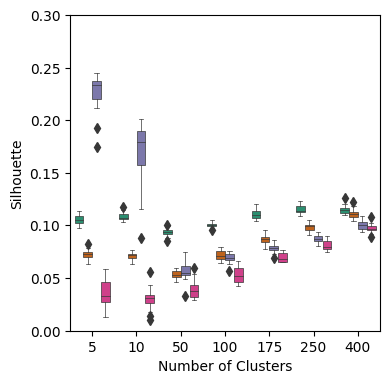

<Figure size 640x480 with 0 Axes>

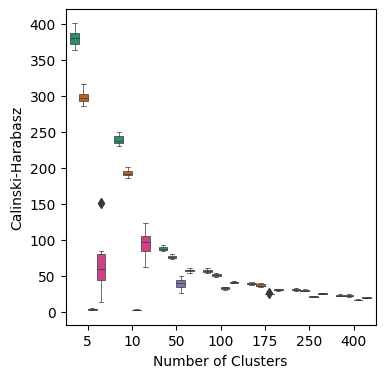

<Figure size 640x480 with 0 Axes>

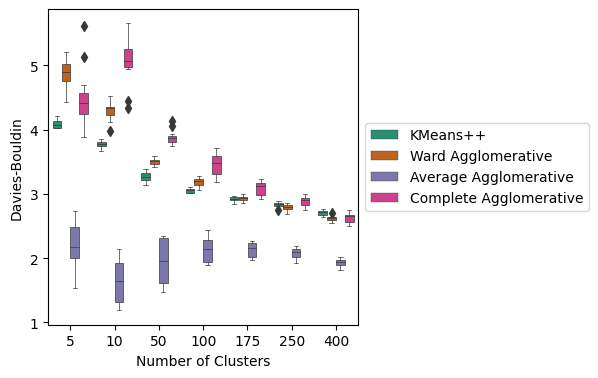

<Figure size 640x480 with 0 Axes>

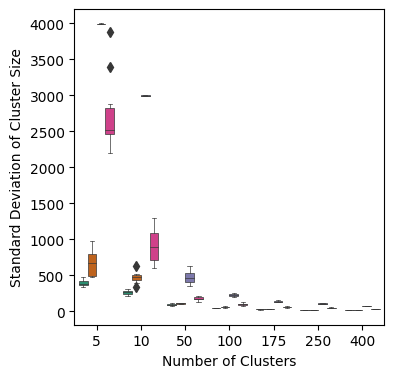

<Figure size 640x480 with 0 Axes>

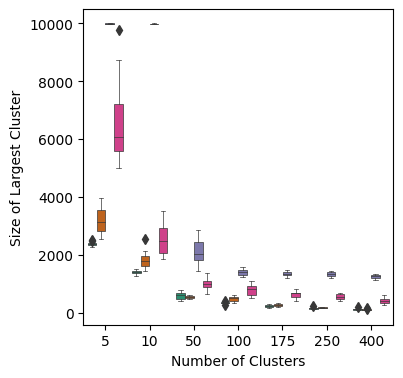

<Figure size 640x480 with 0 Axes>

In [ ]:
for metric_key, save_file in [("Silhouette", "silhouette_averages.png") , ("Calinski-Harabasz", "ch_averages.png"), 
                              ("Davies-Bouldin", "db_averages.png"), 
                              ("Standard Deviation of Cluster Size", "std_dev_cluster_size.png"), ("Size of Largest Cluster", "max_cluster_size.png")]:
    fig = plt.figure(figsize=(4,4.1))
    ax = sns.boxplot( y=metric_key, x="n_clusters", data=model_metrics_df, hue="experiment_label", linewidth=0.5)
    #ax.set_title(f"{metric_key} score averaged across a year of monthly snapshot clustering models")
    ax.set(xlabel="Number of Clusters")
    if metric_key=="Silhouette":
        ax.set(ylim=(0.0, 0.3))
    if metric_key=="Davies-Bouldin":
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.get_legend().remove()
        
    # These get saved in weird sizes - better to just save directly from editor
    # plt.savefig(VIZ_PATH / save_file)
    plt.show()
    plt.clf()

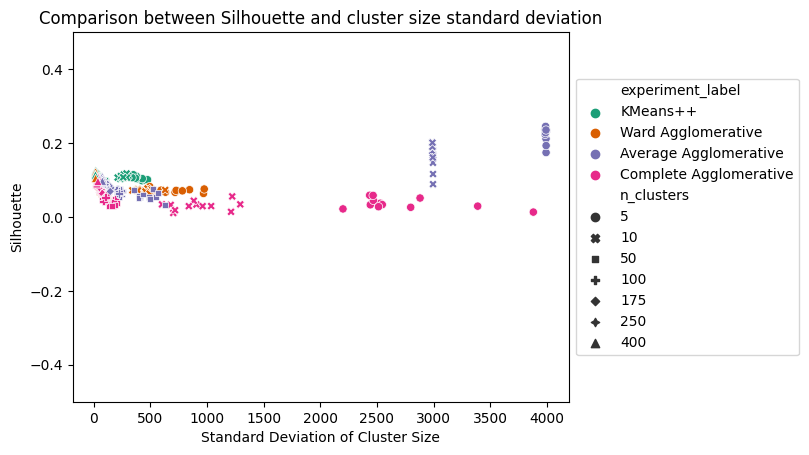

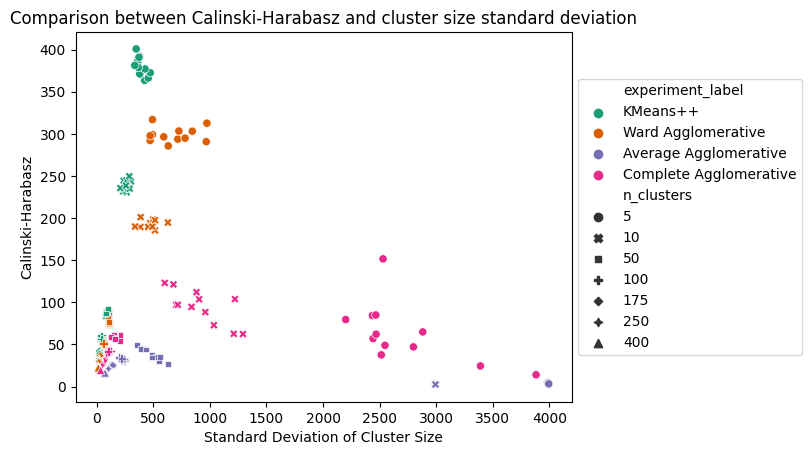

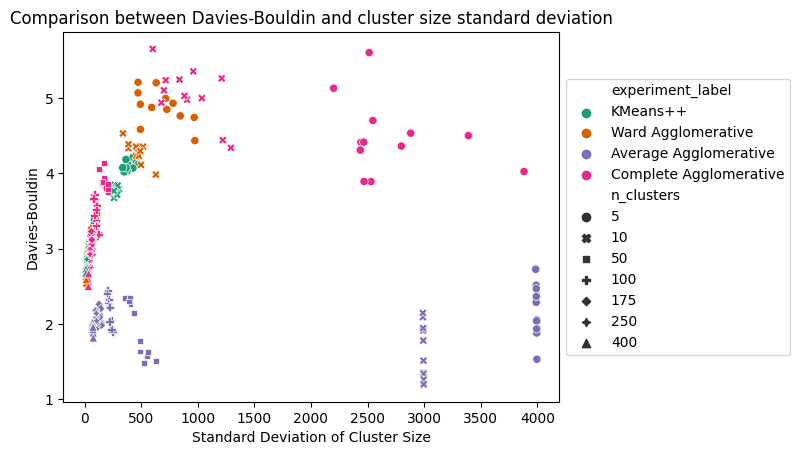

<Figure size 640x480 with 0 Axes>

In [ ]:

for metric_key in ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]:
    ax = sns.scatterplot(y=metric_key, x="Standard Deviation of Cluster Size", data=model_metrics_df, hue="experiment_label", style="n_clusters", linewidth=0.5)
    ax.set_title(f"Comparison between {metric_key} and cluster size standard deviation")
    if metric_key=="Silhouette":
        ax.set(ylim=(-0.5, 0.5))
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()

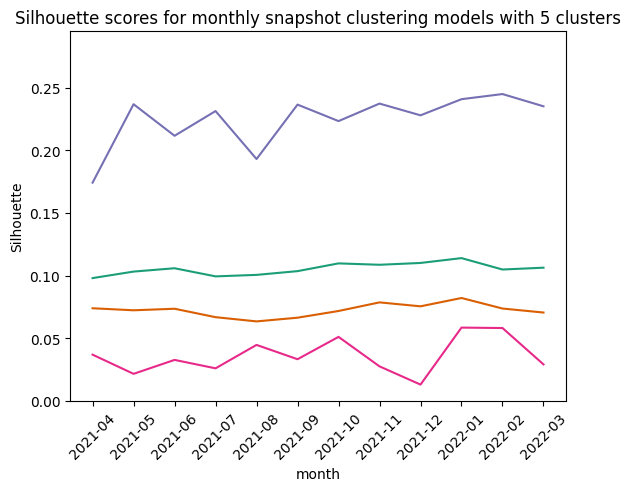

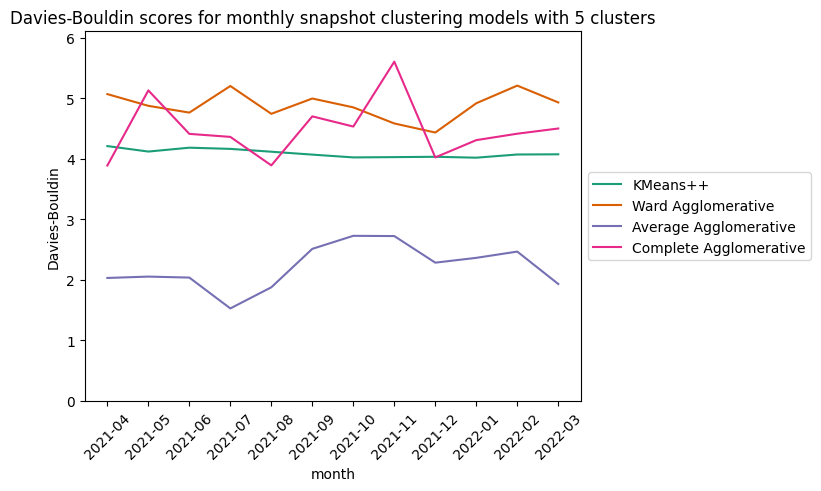

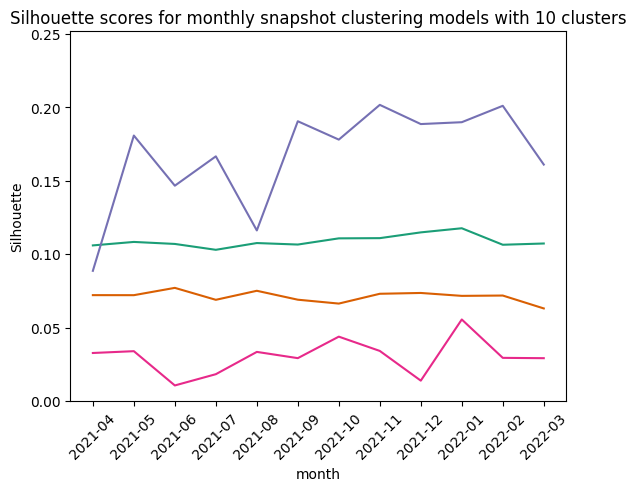

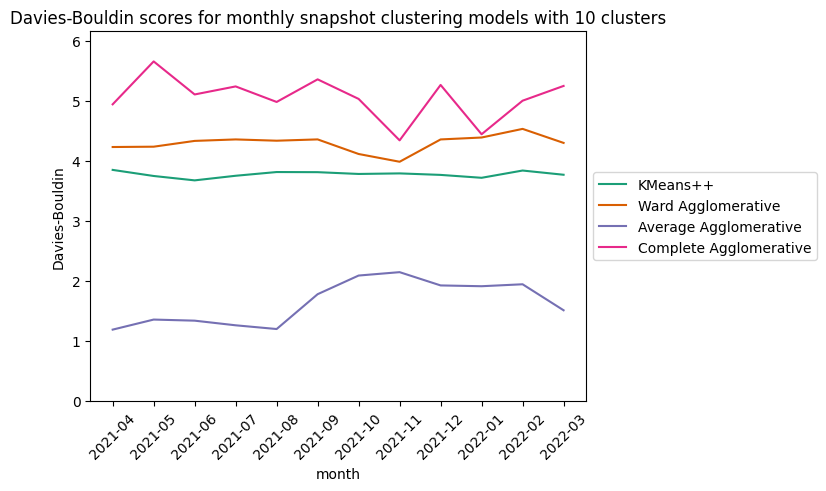

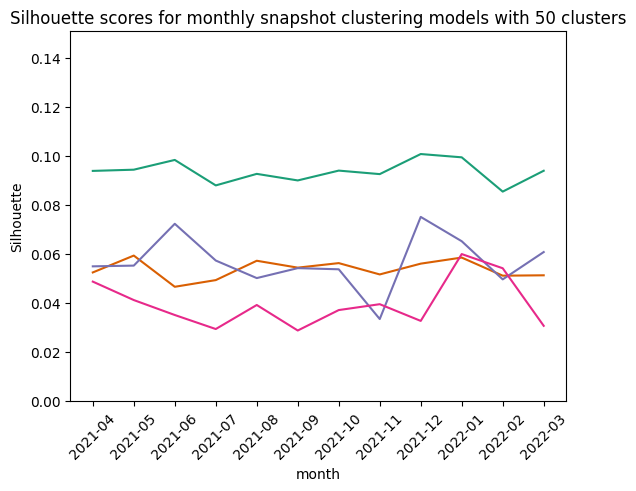

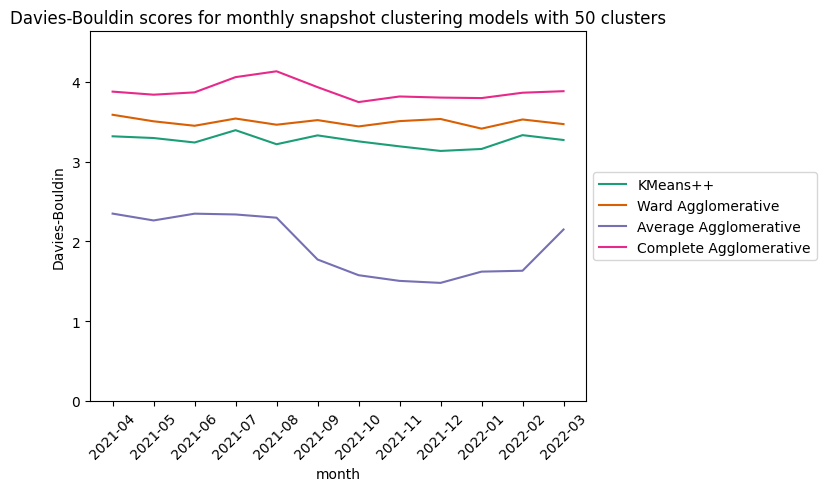

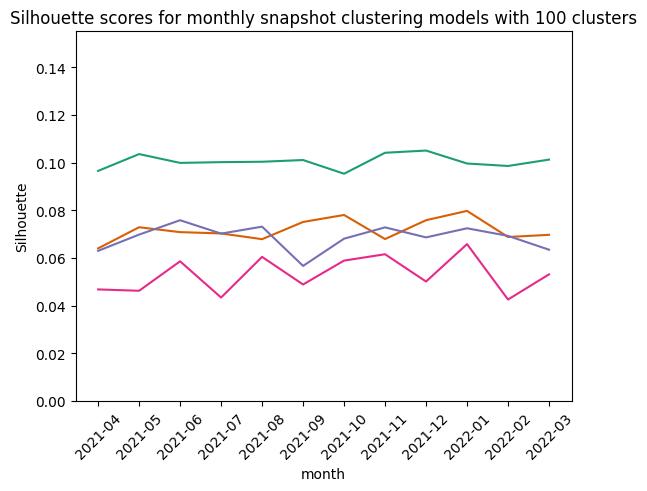

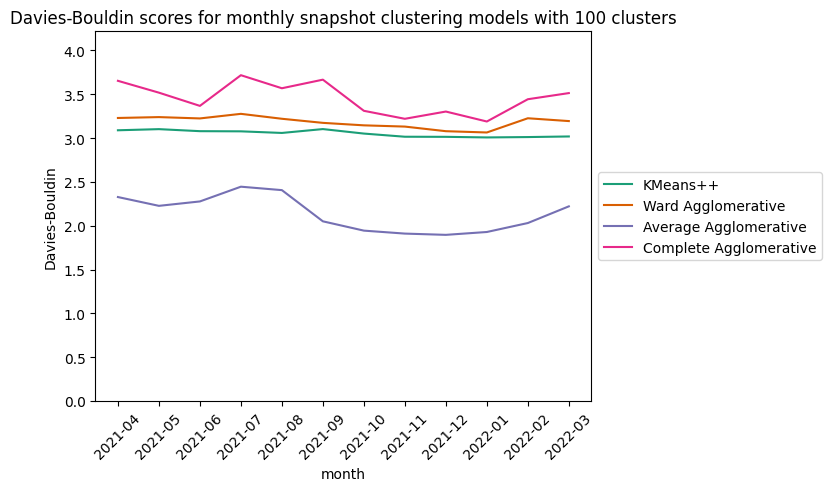

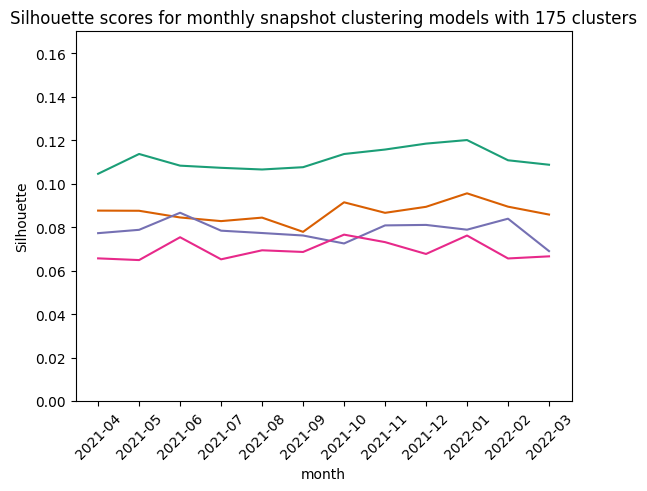

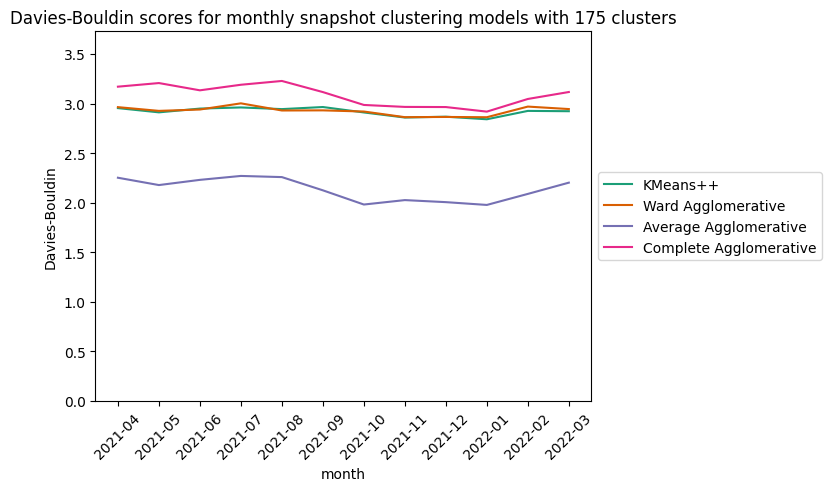

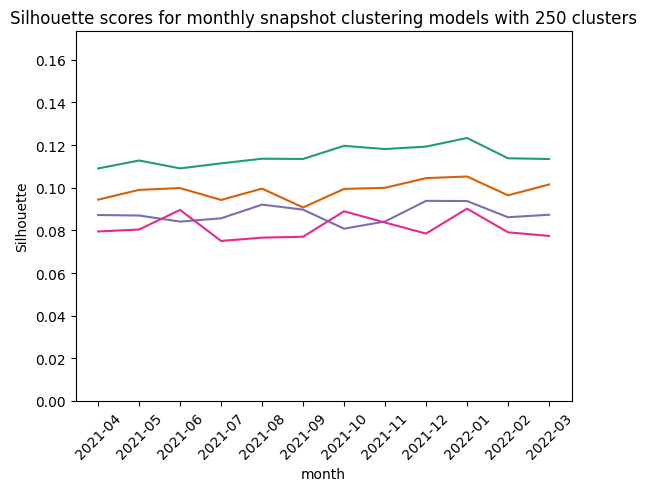

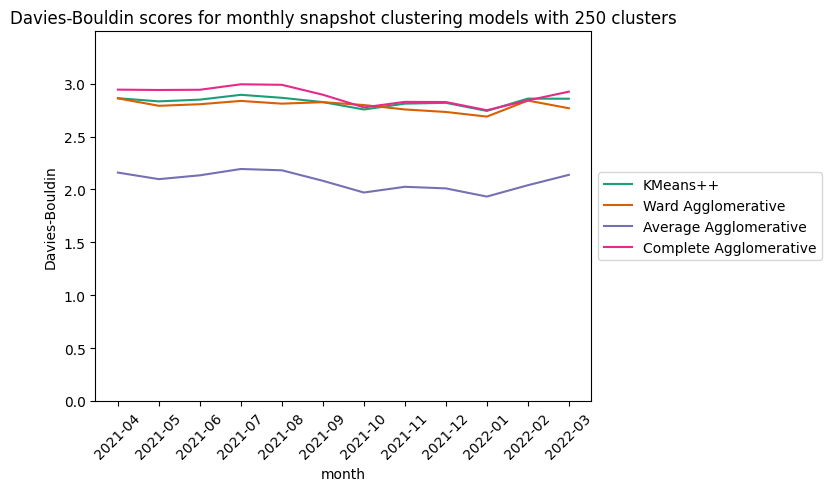

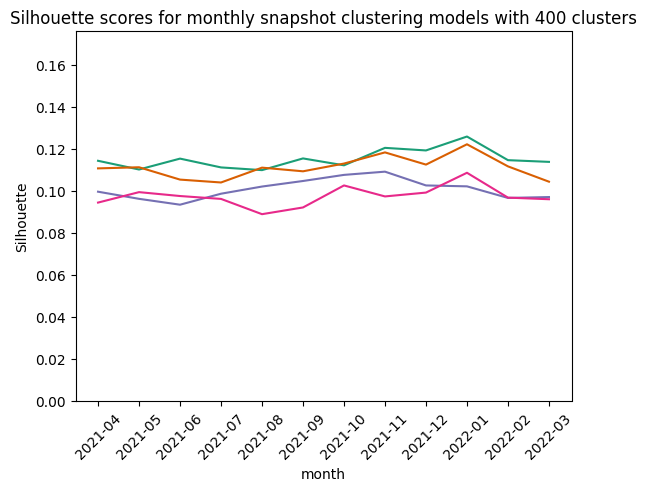

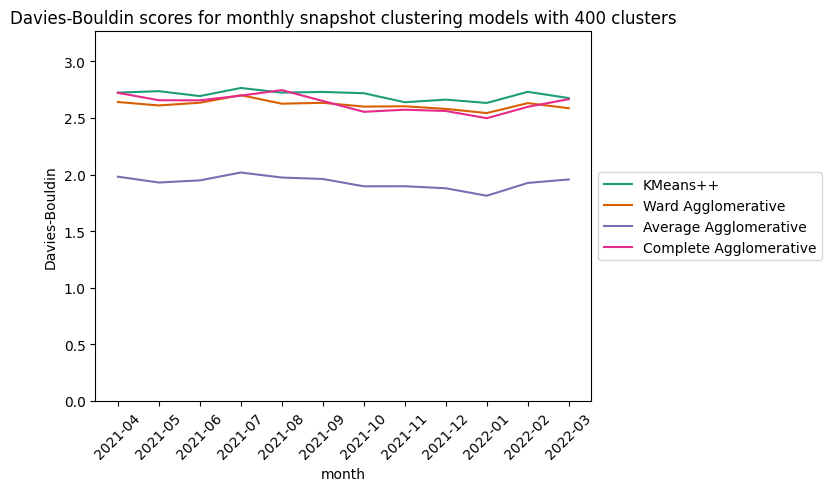

<Figure size 640x480 with 0 Axes>

In [ ]:
for n in N_CLUSTERS:
    tmp_n_cluster_models = model_metrics_df[model_metrics_df["n_clusters"] == n]
    for metric_key in ["Silhouette", "Davies-Bouldin"]:
        ax = sns.lineplot(y=metric_key, x="month", data=tmp_n_cluster_models, hue="experiment_label")
        ax.set_title(f"{metric_key} scores for monthly snapshot clustering models with {n} clusters")
        plt.xticks(rotation=45)
        if metric_key == "Silhouette":
            ax.set(ylim=(0, tmp_n_cluster_models[metric_key].max() + .05))
            ax.legend().remove()
        else:
            ax.set(ylim=(0, tmp_n_cluster_models[metric_key].max() + .5))
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()
        plt.clf()

# Variation of Information across Clustering Model Types
How different are the different clustering models from one month to the next, both within the same treatment and compared to other treatments? 

In [ ]:
vi_df = model_metrics_df[model_metrics_df["n_clusters"]==100]
print(vi_df.shape)
vi_df.head()

(48, 9)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,cluster_size_mean,Standard Deviation of Cluster Size,Size of Largest Cluster,month,experiment_label,n_clusters
144,0.096538,54.870560,3.089468,100.0,39.281802,263,2021-04,KMeans++,100
145,0.064037,49.362964,3.229816,100.0,51.842647,326,2021-04,Ward Agglomerative,100
146,0.062998,32.340681,2.327511,100.0,213.991028,1248,2021-04,Average Agglomerative,100
147,0.046809,40.225900,3.653925,100.0,85.482981,496,2021-04,Complete Agglomerative,100
148,0.103599,55.731349,3.102389,100.0,45.230742,329,2021-05,KMeans++,100


In [ ]:
vi_comparison_results = list()
model_type_pairings = list()
for i, model_a in enumerate(CLUSTER_MODEL_SETTINGS):
    for model_b in CLUSTER_MODEL_SETTINGS[i:]:
        model_type_pairings.append((model_a, model_b))

# Skip comparisons for the same month - there's only one intra-cluster type model, which will lower VI artificially
for model_a_settings, model_b_settings in model_type_pairings:
    for i, month1_tuple in enumerate(zip(MONTHS, C2V_MODELS)):
        month1 = month1_tuple[0]
        month1_c2v = month1_tuple[1]
        month1_data = month1_c2v.get_normed_vectors()
        month1_index = month1_c2v.get_index_as_dict()

        for month2, month2_c2v in zip(MONTHS[i+1:], C2V_MODELS[i+1:]):
            clustering_a_path = MODEL_COMPARISON_ROOT / month1 / "100" / model_a_settings[0]
            clustering_model_a = ic.ClusteringModel.load(clustering_a_path, month1_data, month1_index)
            clustering_a = clustering_model_a.get_cluster_assignments_as_dict()


            month2_data = month2_c2v.get_normed_vectors()
            month2_index = month2_c2v.get_index_as_dict()
            clustering_b_path = MODEL_COMPARISON_ROOT / month2 / "100" / model_b_settings[0]
            clustering_model_b = ic.ClusteringModel.load(clustering_b_path,  month2_data, month2_index)
            clustering_b = clustering_model_b.get_cluster_assignments_as_dict()


            model_a_label = model_a_settings[1].replace(" ", "\n")
            model_b_label = model_b_settings[1].replace(" ", "\n")
            # VOI is symmetric, so we'll just compute results once, but make sure visualization includes both months in heat map
            clustering_comparison_results1  = {"month 1": month1, "month 2": month2, "model a": model_a_label, "model b": model_b_label}
            clustering_comparison_results2  = {"month 1": month2, "month 2": month1, "model a": model_b_label, "model b": model_a_label}
            
            comparison_results = ic.compare_cluterings(clustering_a, clustering_b, use_union=True)
            clustering_comparison_results1.update(comparison_results)
            clustering_comparison_results2.update(comparison_results)

            vi_comparison_results.append(clustering_comparison_results1)
            vi_comparison_results.append(clustering_comparison_results2)

vi_comparison_df = pd.DataFrame.from_records(vi_comparison_results)

In [ ]:
print(vi_comparison_df.shape)
vi_comparison_df.to_csv("vi_inter_clustering.csv", index=False)
display(vi_comparison_df)

(1320, 11)


,month 1,month 2,model a,model b,union_uniform_probability_adjusted_rand_index,union_uniform_probability_rand_index,union_uniform_probability_normalized_mutual_info,union_uniform_probability_homogeneity,union_uniform_probability_completeness,union_uniform_probability_v_measure,union_uniform_probability_variation_of_information
0,2021-04,2021-05,KMeans++,KMeans++,0.299116,0.978745,0.678166,0.676788,0.679549,0.678166,4.060935
1,2021-05,2021-04,KMeans++,KMeans++,0.299116,0.978745,0.678166,0.676788,0.679549,0.678166,4.060935
2,2021-04,2021-06,KMeans++,KMeans++,0.196411,0.969126,0.633606,0.631848,0.635374,0.633606,4.557603
3,2021-06,2021-04,KMeans++,KMeans++,0.196411,0.969126,0.633606,0.631848,0.635374,0.633606,4.557603
4,2021-04,2021-07,KMeans++,KMeans++,0.163836,0.962524,0.629737,0.628707,0.630771,0.629737,4.561835
5,2021-07,2021-04,KMeans++,KMeans++,0.163836,0.962524,0.629737,0.628707,0.630771,0.629737,4.561835
6,2021-04,2021-08,KMeans++,KMeans++,0.139159,0.958296,0.609920,0.607996,0.611855,0.609920,4.776060
7,2021-08,2021-04,KMeans++,KMeans++,0.139159,0.958296,0.609920,0.607996,0.611855,0.609920,4.776060
8,2021-04,2021-09,KMeans++,KMeans++,0.119828,0.953203,0.601254,0.598903,0.603623,0.601254,4.855067
9,2021-09,2021-04,KMeans++,KMeans++,0.119828,0.953203,0.601254,0.598903,0.603623,0.601254,4.855067


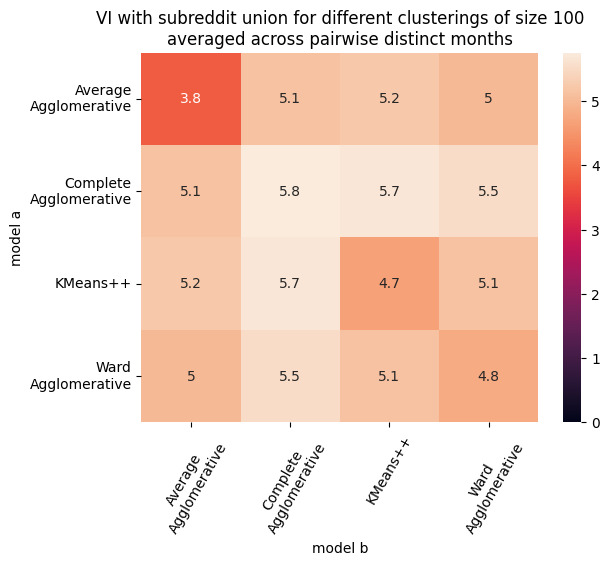

<Figure size 640x480 with 0 Axes>

In [ ]:
voi_col = "union_uniform_probability_variation_of_information"
vmin=0

# Tweak so labels fit better in plot
vi_comparison_df["model a"] = vi_comparison_df["model a"].replace(" ", "\n")
vi_comparison_df["model b"] = vi_comparison_df["model b"].replace(" ", "\n")

vmax= vi_comparison_df[voi_col].max()
vi_averages = vi_comparison_df.pivot_table(index="model a", columns="model b", values= voi_col)
#std_dev_labels = vi_comparison_df.pivot_table(index="model a", columns="model b", values= voi_col, aggfunc='std')
ax = sns.heatmap(vi_averages, vmin=vmin,annot=True)

ax.set(title="VI with subreddit union for different clusterings of size 100\naveraged across pairwise distinct months")
plt.xticks(rotation=60)
plt.savefig(VIZ_PATH /"inter_treatment_inter_month_vi.png", bbox_inches="tight")
plt.show()

plt.clf()